In [2]:
''' make sure to install these dependencies (python3 pip install ... ; or python3 -m pip install ...) '''
!pip install geopy

import pandas as pd
import numpy as np
import re

# import math
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from geopy.distance import geodesic

from numba import set_num_threads

set_num_threads(1)



In [3]:
airTraffic_df = pd.read_csv("data/air_traffic.csv")
avgFare_df = pd.read_csv("data/quarterly_avg_air_fare.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")
faresByCity_df = pd.read_csv("data/city_pair_fares.csv")

In [4]:
airTraffic_df.head()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,160","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,610","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,120","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,260","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07


In [5]:
carriers_df.head()
# carriers_df['UNIQUE_CARRIER']
# carriers_df['DEST_CITY_NAME']


,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,UNIQUE_CARRIER_ENTITY,REGION,CARRIER,CARRIER_NAME,CARRIER_GROUP,CARRIER_GROUP_NEW,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS
0,0.0,0.0,0.0,19.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,Kenmore Air Harbor,1,6,11646,1164601,31646,FBS,"Friday Harbor, WA",US,United States,93,16233,1623301,36233,YWH,"Victoria, Canada",CA,Canada,906,2024,2,6,1,L
1,0.0,0.0,0.0,45.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,Kenmore Air Harbor,1,6,15856,1585601,35856,WSX,"Westsound, WA",US,United States,93,11215,1121501,31215,CXH,"Vancouver, Canada",CA,Canada,906,2024,2,4,1,L
2,0.0,0.0,0.0,47.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,Kenmore Air Harbor,1,6,16229,1622903,31215,YVR,"Vancouver, Canada",CA,Canada,906,11762,1176202,31646,FRD,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
3,0.0,0.0,0.0,53.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,Kenmore Air Harbor,1,6,11215,1121501,31215,CXH,"Vancouver, Canada",CA,Canada,906,11646,1164601,31646,FBS,"Friday Harbor, WA",US,United States,93,2024,2,5,1,L
4,0.0,0.0,0.0,60.0,KAH,20272,Kenmore Air Harbor,06927,D,KAH,Kenmore Air Harbor,1,6,11646,1164601,31646,FBS,"Friday Harbor, WA",US,United States,93,16310,1631001,36016,ZNA,"Nanaimo, Canada",CA,Canada,906,2024,2,6,1,F


In [6]:
pd.set_option('display.max_columns', None)  # Show all columns
print(faresByCity_df.head())

   Year  quarter  citymarketid_1  citymarketid_2  \
0  2009        2           32467           34576   
1  2000        4           30397           33198   
2  2007        4           32575           34614   
3  2004        4           32337           31650   
4  2008        4           30194           30559   

                                 city1                     city2  nsmiles  \
0        Miami, FL (Metropolitan Area)             Rochester, NY     1204   
1      Atlanta, GA (Metropolitan Area)           Kansas City, MO      692   
2  Los Angeles, CA (Metropolitan Area)        Salt Lake City, UT      590   
3                     Indianapolis, IN  Minneapolis/St. Paul, MN      503   
4                Dallas/Fort Worth, TX               Seattle, WA     1670   

   passengers    fare carrier_lg  large_ms  fare_lg carrier_low  lf_ms  \
0         203  151.46         FL      0.29   131.05          FL   0.29   
1         782  172.83         DL      0.63   194.71          NJ   0.26   
2 

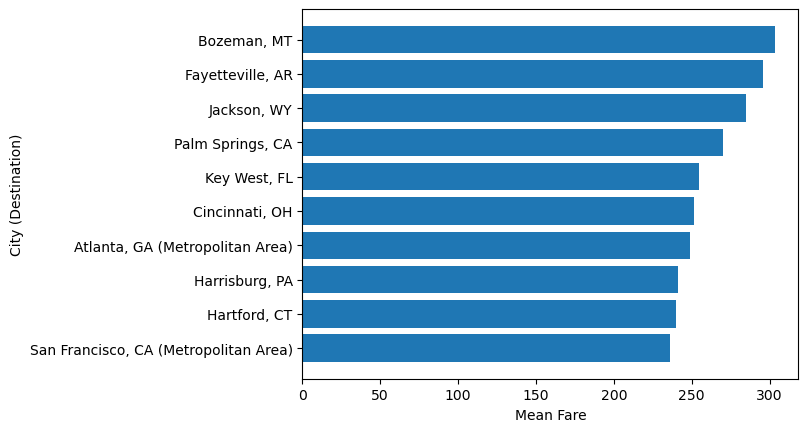

In [7]:
''' Chart 1: avg fare by dest. city '''
# Group, take avg. of fares by city. Sort by fare, asc. #
c1_df = faresByCity_df.groupby('city2')['fare'].mean()
c1_df_sorted = c1_df.sort_values().reset_index()

x = c1_df_sorted.tail(10)['city2']
y = c1_df_sorted.tail(10)['fare']

plt.barh(x,y)
plt.xlabel("Mean Fare")
plt.ylabel("City (Destination)")
plt.show()

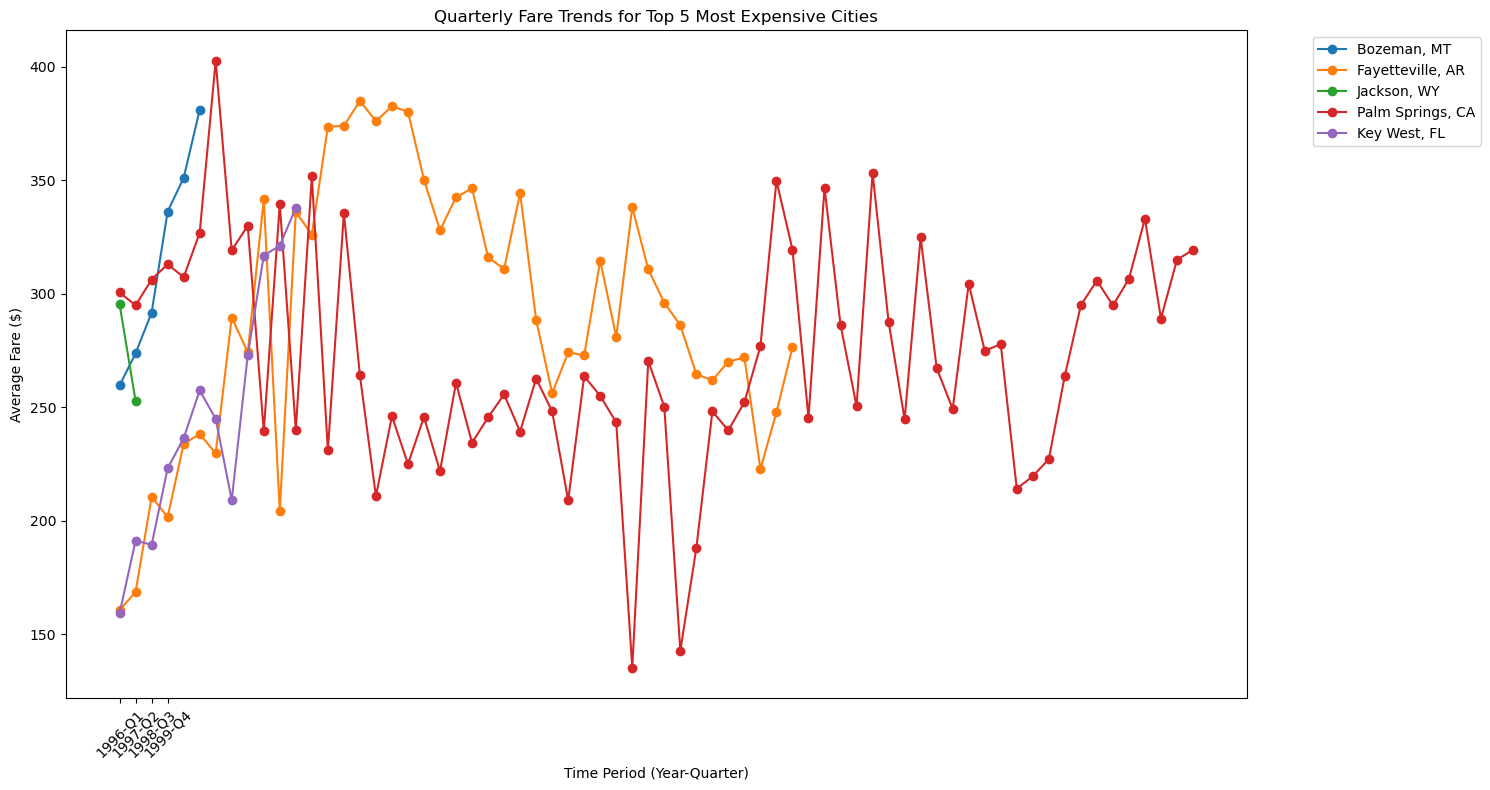

In [8]:
''' Chart 2: Avg. fare by city, by quarter'''
def plot_quarterly_city_fares(faresByCity_df, top_n=5):
    """Plot quarterly fare trends for top N cities by average fare"""
    # Get top N most expensive cities
    top_cities = faresByCity_df.groupby('city2')['fare'].mean().nlargest(top_n).index
    
    # Filter data for top cities
    top_cities_data = faresByCity_df[faresByCity_df['city2'].isin(top_cities)]
    
    # Calculate quarterly averages for each city
    quarterly_avg = top_cities_data.groupby(['Year', 'quarter', 'city2'])['fare'].mean().reset_index()
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    for city in top_cities:
        city_data = quarterly_avg[quarterly_avg['city2'] == city]
        plt.plot(range(len(city_data)), city_data['fare'], label=city, marker='o')
    
    plt.xlabel('Time Period (Year-Quarter)')
    plt.ylabel('Average Fare ($)')
    plt.title(f'Quarterly Fare Trends for Top {top_n} Most Expensive Cities')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create custom x-axis labels
    tick_labels = [f"{year}-Q{quarter}" for year, quarter 
                  in zip(quarterly_avg['Year'].unique(), quarterly_avg['quarter'].unique())]
    plt.xticks(range(len(tick_labels)), tick_labels, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
plot_quarterly_city_fares(faresByCity_df)

In [9]:
'''Chart 3: avg fair by carrier, by quarter'''

'Chart 3: avg fair by carrier, by quarter'

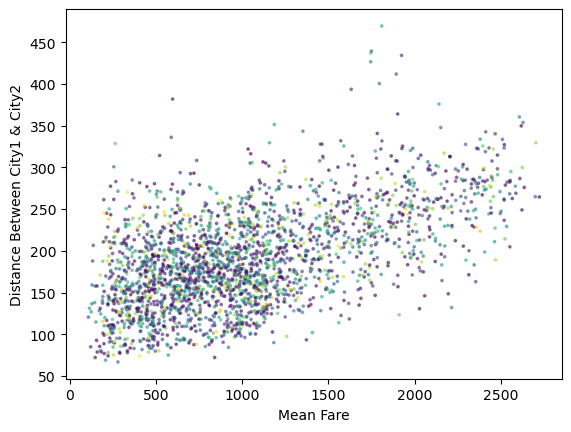

2433


In [10]:
'''Chart 4: Scatter plot by airfare/distance per route'''
def scatter_fare_distance(faresByCity_df):
    faresByRoute= faresByCity_df.groupby(['city1', 'city2','nsmiles'])['fare'].mean()
    faresByRoute_sorted = faresByRoute.sort_values().reset_index()
    
    x = faresByRoute_sorted['nsmiles']
    y = faresByRoute_sorted['fare']
    
    colors = 30*(np.random.rand(len(faresByRoute_sorted))**2)
    area = 3
    
    plt.scatter(x,y, s=area, c=colors,alpha=0.5)
    plt.xlabel("Mean Fare")
    plt.ylabel("Distance Between City1 & City2")
    plt.show()

    print(len(faresByRoute_sorted))

scatter_fare_distance(faresByCity_df)


C:\Users\Avery\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Avery\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Avery\miniconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Avery\miniconda3\Lib\site-packages\spyder_kernels\customize\spydercustomize.py", line 47, in __init__
    super(SubprocessPopen, self).__init__(*args, **kwargs)
  File "C:\Users\Avery\miniconda3\Lib\subprocess.py", line 1026, in __init__
    s

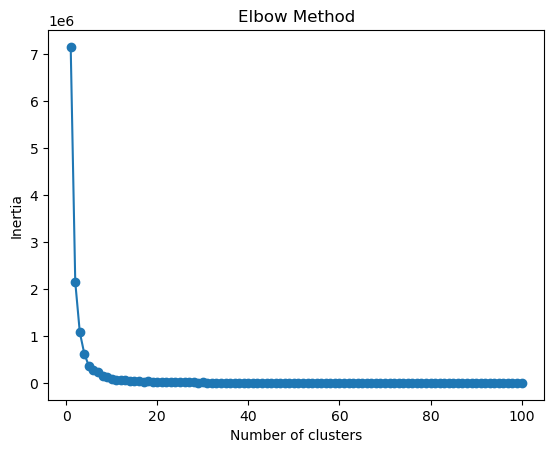

C:\Users\Avery\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


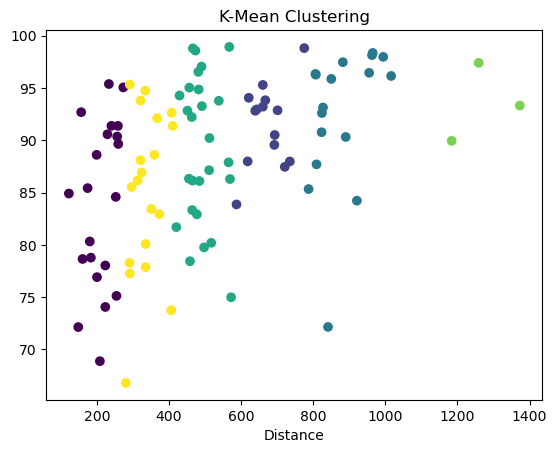

In [11]:
'''Chart 5: K-mean Clustering by airfare/distance per route'''

def plot_k_cluster_price_distance(faresByRoute,x,y):
    # Group, take avg. of fares by city. Sort by fare, asc. #
    faresByRoute= faresByCity_df.groupby(['city1', 'city2','nsmiles'])['fare'].mean()
    faresByRoute_sorted = faresByRoute.sort_values().reset_index()

    N = 100
    data = list(zip(faresByRoute_sorted.head(N)['nsmiles'], faresByRoute_sorted.head(N)['fare']))
    inertias = []
    

    for i in range(1, len(data)+1):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.plot(range(1,len(data)+1), inertias,  marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
    
    x = faresByRoute_sorted.head(N)['nsmiles']
    y = faresByRoute_sorted.head(N)['fare']
    
    kmeans = KMeans(n_clusters = 6)
    kmeans.fit(data)

    plt.scatter(x,y, c=kmeans.labels_)
    plt.title('K-Mean Clustering')
    plt.xlabel('Distance')
    plt.ylabel('')
    plt.show()
    

plot_k_cluster_price_distance(faresByCity_df,x,y)
        

In [10]:
def extract_coordinates(geocoded_str):
    """Extract coordinates from the geocoded string"""
    if pd.isna(geocoded_str):
        return None
    try:
        coord_part = str(geocoded_str).split('\r\n')[1]
        match = re.search(r'\(([-\d.]+),\s*([-\d.]+)\)', coord_part)
        if match:
            return (float(match.group(1)), float(match.group(2)))
        return None
    except:
        return None

def calculate_distance(coord1, coord2):
    """Calculate distance between two coordinate pairs"""
    if coord1 is None or coord2 is None:
        return None
    return geodesic(coord1, coord2).miles

def prepare_data(faresByCity_df, carriers_df):
    """Prepare data with carrier prices from both carriers"""
    expanded_rows = []
    
    for _, row in faresByCity_df.iterrows():
        # Add first carrier if fare exists
        if pd.notna(row['fare_lg']):
            expanded_rows.append({
                'city1': row['city1'],
                'city2': row['city2'],
                'nsmiles': row['nsmiles'],
                'quarter': row['quarter'],
                'passengers': row['passengers'],
                'carrier': row['carrier_lg'],
                'market_share': row['large_ms'],
                'fare': row['fare_lg'],
                'Geocoded_City1': row['Geocoded_City1'],
                'Geocoded_City2': row['Geocoded_City2']
            })
        
        # Add second carrier if fare exists
        if pd.notna(row['fare_low']):
            expanded_rows.append({
                'city1': row['city1'],
                'city2': row['city2'],
                'nsmiles': row['nsmiles'],
                'quarter': row['quarter'],
                'passengers': row['passengers'],
                'carrier': row['carrier_low'],
                'market_share': row['lf_ms'],
                'fare': row['fare_low'],
                'Geocoded_City1': row['Geocoded_City1'],
                'Geocoded_City2': row['Geocoded_City2']
            })
    
    # Create DataFrame with both carriers
    expanded_df = pd.DataFrame(expanded_rows)
    
    # Drop any remaining rows with NaN values
    expanded_df = expanded_df.dropna()
    
    # Extract coordinates once and store them
    print("Extracting coordinates...")
    expanded_df['origin_coords'] = expanded_df['Geocoded_City1'].apply(extract_coordinates)
    expanded_df['dest_coords'] = expanded_df['Geocoded_City2'].apply(extract_coordinates)
    
    # Drop rows where coordinate extraction failed
    expanded_df = expanded_df.dropna(subset=['origin_coords', 'dest_coords'])
    
    # Create encoders
    origin_encoder = LabelEncoder()
    dest_encoder = LabelEncoder()
    
    
    # Encode features
    expanded_df['origin_encoded'] = origin_encoder.fit_transform(expanded_df['city1'])
    expanded_df['dest_encoded'] = dest_encoder.fit_transform(expanded_df['city2'])
    carrier_dummies = pd.get_dummies(expanded_df['carrier'], prefix='carrier')
    
    # Create feature matrix
    X = pd.concat([
    pd.DataFrame({
        'distance': expanded_df['nsmiles'],
        'quarter': expanded_df['quarter'],
        'passengers': expanded_df['passengers'],
        'origin': expanded_df['origin_encoded'],
        'destination': expanded_df['dest_encoded'],
        'market_share': expanded_df['market_share']
        }),
        carrier_dummies
    ], axis=1)
    
    carrier_list = list(expanded_df['carrier'].unique())  # Convert to list explicitly
    return X, expanded_df['fare'], origin_encoder, dest_encoder, carrier_list, expanded_df

# Initialize model and data
print("Loading data...")
faresByCity_df_original = pd.read_csv("data/city_pair_fares.csv")
carriers_df = pd.read_csv("data/carriers_routes.csv")

print("Preparing data...")
X, y, origin_encoder, dest_encoder, carrier_list, model_df = prepare_data(faresByCity_df_original, carriers_df) 

print("Training model...")
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
model.fit(X, y)

Loading data...
Preparing data...
Extracting coordinates...


NameError: name 'LabelEncoder' is not defined

In [18]:
def predict_route_fare(model, origin_city, dest_city, quarter, passengers, carrier,
                      origin_encoder, dest_encoder, carrier_list, 
                      faresByCity_df, carriers_df):
    """Predict fare for any city pair with specific carrier"""
    try:
        # Check if direct route exists
        direct_route = faresByCity_df[
            (faresByCity_df['city1'] == origin_city) & 
            (faresByCity_df['city2'] == dest_city)
        ]
        
        route_exists = len(direct_route) > 0
        if route_exists:
            distance = direct_route['nsmiles'].iloc[0]
            route_carriers = {
                direct_route['carrier_lg'].iloc[0], 
                direct_route['carrier_low'].iloc[0]
            }
            carrier_serves_route = carrier in route_carriers
            
            if carrier == direct_route['carrier_lg'].iloc[0]:
                market_share = direct_route['large_ms'].iloc[0]
            elif carrier == direct_route['carrier_low'].iloc[0]:
                market_share = direct_route['lf_ms'].iloc[0]
            else:
                market_share = 0.5
        else:
            origin_coords = get_city_coordinates(origin_city, faresByCity_df, is_origin=True)
            dest_coords = get_city_coordinates(dest_city, faresByCity_df, is_origin=False)
            distance = calculate_distance(origin_coords, dest_coords)
            carrier_serves_route = False
            market_share = 0.5
        
        # Encode cities
        origin_encoded = origin_encoder.transform([origin_city])[0]
        dest_encoded = dest_encoder.transform([dest_city])[0]
        
        # Create one-hot carrier encoding
        carrier_features = {f'carrier_{c}': 1 if c == carrier else 0 for c in carrier_list}
        
        # Create prediction data
        X_pred = pd.DataFrame({
            'distance': [distance],
            'quarter': [quarter],
            'passengers': [passengers],
            'origin': [origin_encoded],
            'destination': [dest_encoded],
            'market_share': [market_share],
            **carrier_features
        })
        
        predicted_fare = model.predict(X_pred)[0]
        
        return {
            'predicted_fare': f"${predicted_fare:.2f}",
            'distance': f"{distance:.1f} miles",
            'origin': origin_city,
            'destination': dest_city,
            'carrier': carrier,
            'quarter': f"Q{quarter}",
            'passengers': passengers,
            'route_exists': route_exists,
            'carrier_serves_route': carrier_serves_route,
            'market_share': f"{market_share*100:.1f}%"
        }
        
    except Exception as e:
        return f"Error making prediction: {str(e)}"

def get_fare_prediction(origin, destination, quarter, passengers, carrier):
    return predict_route_fare(
        model=model,
        origin_city=origin,
        dest_city=destination,
        quarter=quarter,
        passengers=passengers,
        carrier=carrier,
        origin_encoder=origin_encoder,
        dest_encoder=dest_encoder,
        carrier_list=carrier_list,  # Changed from carrier_encoder
        faresByCity_df=faresByCity_df_original,
        carriers_df=carriers_df
    )

In [19]:
# Test one route
test_pred = predict_route_fare(
    model=model,
    origin_city="Denver, CO",
    dest_city="Seattle, WA",
    quarter=4,
    passengers=10,
    carrier="DL",
    origin_encoder=origin_encoder,
    dest_encoder=dest_encoder,
    carrier_list=carrier_list,
    faresByCity_df=faresByCity_df_original,
    carriers_df=carriers_df
)
print("\nTest prediction:")
print(test_pred)

NameError: name 'model' is not defined